# Melanoma Detection using CNN

<hr style="border:1px solid blue">

An assignment to create, compile and train a Convolutional Neural Network (CNN) model to classify 9 types of skin cancer accurately.

### Project Description

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths.

#### Data Set Brief Information
A zipped file containing 2 folders - Train and Test are given.<br>
Train and Testfolders are present for training-validation and predicting the model respectively.<br>
Each folder contains sub-folders with names of 9 types of skin cancer.<br>
These sub-folders contains respective skin cancer images.

#### Business Objective
Create, compile and train a CNN based model which can classify 9 types of skin cancer accurately.

#### Business Solution
The trained model is provided as a solution, which can evaluate images and alert the dermatologists about the presence of melanoma, that can reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
# Import pathlib for getting file path
import pathlib
# Import tensorflow
import tensorflow as tf
# Import numpy
import numpy as np
# Import pandas
import pandas as pd
# Import OS
import os
# Import PIL
import PIL
# Import keras from tensorflow
from tensorflow import keras
# Import layers for building CNN
from tensorflow.keras import layers
# Import Sequential
from tensorflow.keras.models import Sequential
# Importing matplotlib library
import matplotlib.pyplot as plt
# Import gridspec for plotting detailed graph
import matplotlib.gridspec as gridspec
# To enable the inline plotting
%matplotlib inline
# Importing seaborn
import seaborn as sns
# Importing load image
from tensorflow.keras.preprocessing.image import load_img
# Set tensorflow log level to report only ERROR - this removes warning created by image augmentation layer in model
tf.get_logger().setLevel('ERROR')
# Ignore warnings due to library versions
import warnings
warnings.filterwarnings("ignore")
# Import metrics from sklearn library
from sklearn import metrics

### Importing Skin Cancer Data

**Note** : If not using Google Colab to run this notebook, comment the below code cell to avoid error. `drive` library is only available in Google Colab! This library is used to mount google drive and change directory to 'My Drive'.
* Use `wget` command, download the shared zip package from upGrad's google drive to your current directory.
* Use `unzip` command to unzip the zip package to your current directory.

In [2]:
# Import drive from Google Colab
from google.colab import drive
# Mount Google Drive
drive.mount('/content/gdrive')
# Change current directory to 'My Drive'
os.chdir('gdrive/My Drive/')

In [3]:
# Download dataset via wget method. Downloading Large files (>100 MB) requires virus checks, hence downloading the data in silent mode with temporary cookies and no certificate
# Avoid new download by -nc option, if file is available in google drive.
# Note: file id and file name is as per link shared by UpGrad google drive link - https://drive.google.com/file/d/1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs/view?usp=sharing
!wget -nc --no-check-certificate --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xLfSQUGDl8ezNNbUkpuHOYvSpTyxVhCs" -O CNN_assignment.zip && rm -rf /tmp/cookies.txt

In [4]:
# Unzip the zip folder - CNN_assignment.zip
!unzip -q -n -u 'CNN_assignment.zip'

**Observation** : This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [6]:
# Count total Images avaiable in train and test dataset
image_count_train = len(list(data_dir_train.rglob('*/*.jpg')))
print('Train dataset have {} images'.format(image_count_train))
image_count_test = len(list(data_dir_test.rglob('*/*.jpg')))
print('Test dataset have {} images'.format(image_count_test))
print('\nTotal dataset have {} images'.format(image_count_test + image_count_train))

Train dataset have 2239 images
Test dataset have 118 images

Total dataset have 2357 images


### Creating Dataset for ML

Let's load these images off disk using the helpful image_dataset_from_directory utility. Use 80% of the images for training, and 20% for validation.

In [7]:
# Defining parameters for image_dataset_from_directory utility
# Size of the batches of data
batch_size = 32
# Size to resize images to after they are read from disk, specified as (height, width)
img_height = 180
img_width = 180

In [8]:
# Resize images to the size img_height*img_width, while reading the dataset - training
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,
                                                       validation_split=0.2,
                                                       subset='training',
                                                       batch_size=batch_size,
                                                       image_size=(img_height, img_width),
                                                       seed=123)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
# Resize images to the size img_height*img_width, while reading the dataset - validation
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,
                                                     validation_split=0.2,
                                                     subset='validation',
                                                     batch_size=batch_size,
                                                     image_size=(img_height, img_width),
                                                     seed=123)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# Print shapes of image and labels of training and validation of one batch
for images, labels in train_ds.take(1): # take() - takes a single batch (images and label) from train_ds dataset
  print("The Training Batch is of shape {}, and the Classification labels are of shape {}".format(images.shape, labels.shape))

for images, labels in val_ds.take(1): # take() - takes a single batch (images and label) from val_ds dataset
  print("The Validation Batch is of shape {}, and the Classification labels are of shape {}".format(images.shape, labels.shape))

The Training Batch is of shape (32, 180, 180, 3), and the Classification labels are of shape (32,)
The Validation Batch is of shape (32, 180, 180, 3), and the Classification labels are of shape (32,)


**Observation** : The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [11]:
# List out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names # Class names
num_classes = len(class_names) # Get number of classes
list_of_files = [] # List to store first file in each sub directory
count_files = [] # List to store number of files in each sub directory
print('Class names are:\n')
for name in class_names:
    temp_path = os.path.join(data_dir_train, name) # Join file path with class name
    count_files.append(len(os.listdir(temp_path))) # Count all files
    list_of_files.append(os.path.join(temp_path, os.listdir(temp_path)[0])) # Get first file from each class folder
    print(name)

Class names are:

actinic keratosis
basal cell carcinoma
dermatofibroma
melanoma
nevus
pigmented benign keratosis
seborrheic keratosis
squamous cell carcinoma
vascular lesion


### Visualize the data

Visualizing one instance of all the nine classes present in the dataset.

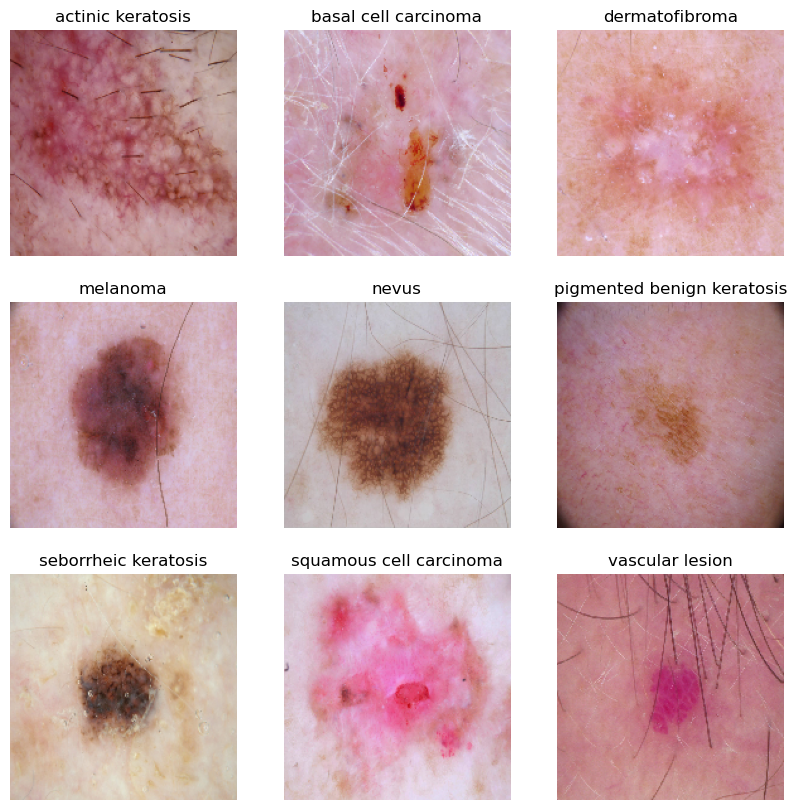

In [12]:
# Plotting from train dataset
plt.figure(figsize=(10, 10))
for i in range(num_classes): # loop through all classes in batch
    ax = plt.subplot(3, 3, i + 1) # keep subplotting the image
    plt.imshow(load_img(list_of_files[i], target_size=(img_height, img_width))) # Show images from each class folder
    plt.title(class_names[i]) # display title from class name list
    plt.axis("off") # turn off axis for image display

### Pre-fetch images

tf.data builds a performance model of the input pipeline and runs an optimization algorithm to find a good allocation of its CPU budget across all parameters specified as `AUTOTUNE`.
* `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.
* `Dataset.prefetch()` overlaps data preprocessing and model execution while training.
* `Dataset.shuffle()`shuffle the samples to have always a random order of samples fed to the network

In [13]:
# Pre-fecth buffer
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
* Use `layers.experimental.preprocessing.Rescaling` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

* Create a CNN model, which can accurately detect 9 classes present in the dataset.

In [14]:
# Specify input dimensions of each image
channels = 3 # RGB - 3 channels
input_shape = (img_height, img_width, channels) # (180, 180, 3)

In [15]:
# model
model = Sequential()

# At first, we will add rescaling layer to normalize pixel range from (0 to 255) to (0, 1)
model.add(layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=input_shape))

# First conv layer
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
# First max pool layer
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Second conv layer
model.add(layers.Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
# Second max pool layer
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2)))

# Third conv layer
model.add(layers.Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))
# Third max pool layer
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layer or fully connected layer
model.add(layers.Dense(512, activation='relu'))

# Dense layer or fully connected layer
model.add(layers.Dense(64, activation='relu'))

# Softmax layer
model.add(layers.Dense(num_classes, activation='softmax'))

### Compile the model
* `Optimizer` - **Adam** optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. It have faster computation time, and require fewer parameters for tuning.
* `Sparse Categorical Cross Entropy` - Computes the categorical crossentropy loss when tensor is **not** one-hot encoded.

In [16]:
# Compile the model with optimiser and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Understanding Model Summary
Let's do some calculations to verify that we understand the model deeply enough. The first element None is for the batch size (32).<br>
The output size is calculated using ```(((N + (2 * P) - K) / S) + 1)```, where:<br>
N => Input Shape size<br>
P => Padding value<br>
K => Kernal size<br>
S => Stride value<br>
<br>
* `Rescaling` layer takes input of shape 180 x 180 x 3 pixels and rescales it in the range of [0,1].  No trainable parameters for this layer.
* `Convolution 2D - First layer` have stride of 1 and zero padding. It uses 32 kernals of size 3 x 3 and each kernel has a single bias. The kernels have only one channel since the input images are 2D (grayscale). So, we have 32 x 3 x 3 (weights) x 3 (channels) + 32 (biases) = 896 parameters (all trainable). The output size is (((180 + (2 * 0) - 3) / 1) + 1) = 178. Hence output shape is 178 x 178 x 32, where channels changed from 3 to 32 feature maps. Activation function is RELU.
* `Max Pooling - First layer` have S and K as 2 and P as 0. The output size is (((178 + (2 * 0) - 2) / 2) + 1) = 89. Hence output shape is 89 x 89 x 32. No trainable parameters for this layer.
* `Convolution 2D - Second layer` have stride of 1 and zero padding. It uses 64 kernals of size 3 x 3 and each kernel has a single bias. So, we have 64 x 3 x 3 (weights) x 32 (features) + 64 (biases) = 18496 parameters (all trainable). The output size is (((89 + (2 * 0) - 3) / 1) + 1) = 87. Hence output shape is 87 x 87 x 64, where feature maps became 64. Activation function is RELU.
* `Max Pooling - Second layer` have S is 2, K is 3 and P is 0. The output size is (((87 + (2 * 0) - 3) / 2) + 1) = 43. Hence output shape is 43 x 43 x 64. No trainable parameters for this layer.
* `Convolution 2D - Third layer` have stride of 1 and zero padding. It uses 128 kernals of size 3 x 3 and each kernel has a single bias. So, we have 128 x 3 x 3 (weights) x 64 (features) + 128 (biases) = 73856 parameters (all trainable). The output size is (((43 + (2 * 0) - 3) / 1) + 1) = 41. Hence output shape is 41 x 41 x 128, where feature maps became 128. Activation function is RELU.
* `Max Pooling - Third layer` have S is 2, K is 3 and P is 0. The output size is (((41 + (2 * 0) - 3) / 2) + 1) = 20. Hence output shape is 20 x 20 x 128. No trainable parameters for this layer.
* `Flatten Layer` have no trainable parameters. The output size is 20 x 20 x 128 = 51200. Hence output shape is 51200. So, we have 51200 neurons.
* `Dense Layer 1` have 512 neurons and its corresponding bias. The output size is 51200 x 512 + 512 = 26214912 parameters (all trainable). Hence output shape is 26214912. Activation function is RELU.
* `Dense Layer 2` have 64 neurons and its corresponding bias. The output size is 512 x 64 + 64 = 32832 parameters (all trainable). Hence output shape is 32832. Activation function is RELU.
* `Dense Layer 3` have 9 neurons (corresponding to nine classes) and its corresponding bias. The output size is 64 x 9 + 9 = 585 parameters (all trainable). Hence output shape is 585. Activation function is SoftMAX. This layer finally classifies images based on maximum probability obtained for all classes.

### Train the model

We will train the model for 20 epochs.

In [18]:
# epochs - training of the neural network with all the training data for one cycle
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 91s 1s/step - loss: 2.0722 - accuracy: 0.2500 - val_loss: 1.7529 - val_accuracy: 0.3624
Epoch 2/20
56/56 [==============================] - 75s 1s/step - loss: 1.7456 - accuracy: 0.3700 - val_loss: 1.6458 - val_accuracy: 0.4206
Epoch 3/20
56/56 [==============================] - 75s 1s/step - loss: 1.6208 - accuracy: 0.4219 - val_loss: 1.5082 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - 74s 1s/step - loss: 1.4573 - accuracy: 0.4877 - val_loss: 1.3831 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 77s 1s/step - loss: 1.3480 - accuracy: 0.5234 - val_loss: 1.3973 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 76s 1s/step - loss: 1.3772 - accuracy: 0.5106 - val_loss: 1.6704 - val_accuracy: 0.4787
Epoch 7/20
56/56 [==============================] - 75s 1s/step - loss: 1.3143 - accuracy: 0.5352 - val_loss: 1.3876 - val_accuracy: 0.5011
Epoch 8/20
56/56 [==

### Visualizing training results

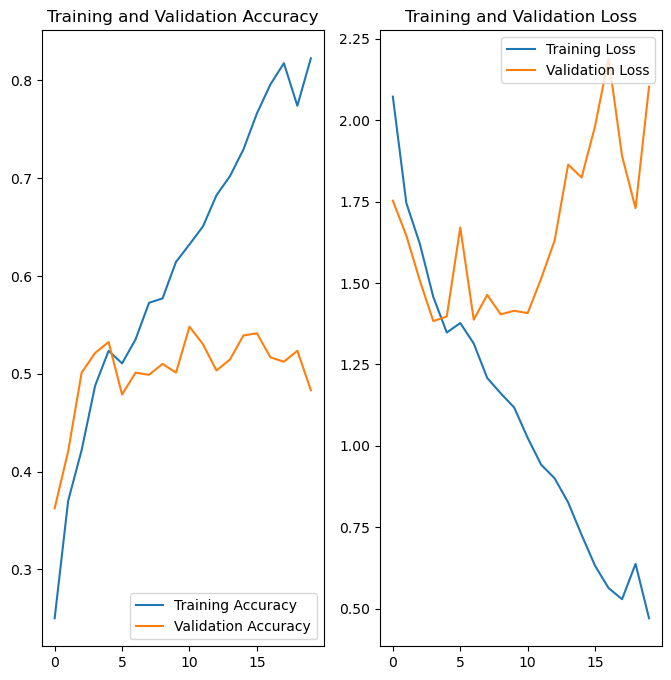

In [19]:
# Function to plot model performance on training and validation dataset
def plot_model_outcome(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Plot model performance
plot_model_outcome(history, epochs)

### Observation
Model is overfitting - Training accuracy is 88% and validation accuracy is ~50%.
From the above Training vs Validation accuracy graph we can see that as the epoch increases the difference between Training accuracy and validation accuracy increases. Also loss of both data set have big marginal difference. Hence this model is not acceptable.

### Data Augmentation
Create a data augmentation layer to modify image for better feature mapping.
* `RandomContrast` - Adds a contrast to image to highlight colour of cancerous skin in range (0.9,1.9)
* `RandomRotation` - Rotates images randomly.
* `RandomZoom` - Zooms in image with (+20,+30)% vertically and horizontally.

In [20]:
# Create augmentation layer
augmentation_layer = keras.Sequential([
    layers.experimental.preprocessing.RandomContrast(factor=0.1, seed=123, input_shape=input_shape),
    layers.experimental.preprocessing.RandomRotation(factor=0.2, fill_mode='reflect', seed=123),
    layers.experimental.preprocessing.RandomZoom(height_factor=(-0.2, -0.3), width_factor=(-0.2, -0.3), fill_mode='reflect', seed=123)
])

### Visualizing Data Augmentation
Visualizing the after effects of applying data augmentation layer on images. Display one instance of all the nine classes present in the dataset and its corresponding modified image.

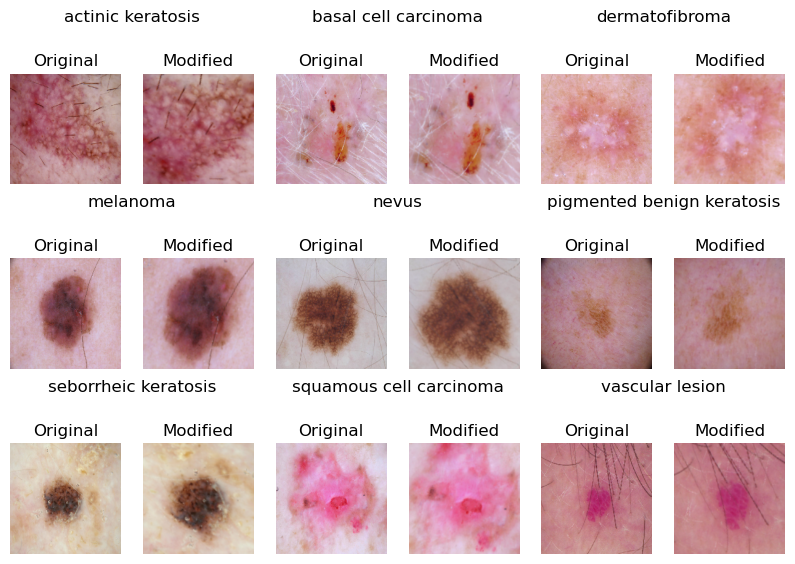

In [21]:
# Plotting original and modified images from train dataset
fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(6, 6, height_ratios=[0.2,2,0.2,2,0.2,2])
m_row = 0
m_col = 0
m_span = 0
# loop through all classes in batch
for i in range(num_classes):
    img = load_img(list_of_files[i], target_size=(img_height, img_width)) # Load image
    img = keras.preprocessing.image.img_to_array(img) # Conver PIL to array
    img = np.expand_dims(img, axis=0) # Expand dimensions
    img = tf.convert_to_tensor(np.array(img)) # Convert to tensor
    ax_class = fig.add_subplot(gs[m_row, m_span:(m_span+2)])
    ax_org = fig.add_subplot(gs[(m_row+1), m_col])
    ax_mod = fig.add_subplot(gs[(m_row+1), (m_col+1)])
    # Plot original image
    ax_org.imshow(img.numpy().astype("uint8").reshape((img_height, img_width, 3)))
    # Plot modified image after applying augmentation layer on original image
    ax_mod.imshow(augmentation_layer(img).numpy().astype("uint8").reshape((img_height, img_width, 3)))
    ax_class.set_title(class_names[i])
    ax_class.axis("off")
    ax_org.set_title('Original')
    ax_org.axis("off")
    ax_mod.set_title('Modified')
    ax_mod.axis("off")
    m_span += 2
    m_col += 2
    if m_col % 6 == 0:
        m_col = 0
        m_span = 0
        m_row += 2

In [22]:
# Pre-fecth buffer
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
* Create a ML model with data augmentation layer.
* Add a `dropout layer`. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

In [23]:
# model
model = Sequential()

# At first, we will add image augmentation layer
model.add(augmentation_layer)

# We will add rescaling layer to normalize pixel range from (0 to 255) to (0, 1)
model.add(layers.experimental.preprocessing.Rescaling(1. / 255))

# First conv layer
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
# First max pool layer
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Dropout layer with 0.25 rate
model.add(layers.Dropout(0.25))

# Second conv layer
model.add(layers.Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
# Second max pool layer
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# Dropout layer with 0.25 rate
model.add(layers.Dropout(0.25))

# Third conv layer
model.add(layers.Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))
# Third max pool layer
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# Dropout layer with 0.25 rate
model.add(layers.Dropout(0.25))

# Flatten layer
model.add(layers.Flatten())

# Dense layer or fully connected layer
model.add(layers.Dense(512, activation='relu'))
# Dropout layer with 0.25 rate
model.add(layers.Dropout(0.25))

# Dense layer or fully connected layer
model.add(layers.Dense(64, activation='relu'))
# Dropout layer with 0.5 rate
model.add(layers.Dropout(0.5))

# Softmax layer
model.add(layers.Dense(num_classes, activation='softmax'))

### Compile the model

In [24]:
# Compile the model with optimiser and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [25]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 89, 89, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                      

### Understanding Model Summary
We are using same model as before with few modifications:
* `Image Augmentation Layer` is added at beginning of model preprocessing to apply Random contrast, rotation and zoom in to images. No trainable parameters.
* `Dropout Layer` of rate 25% is added after every max pooling layer and first dense layer. A 50% drop rate is used after second dense layer. No trainable parameters. The output shape is same as input shape.

### Train the model

In [26]:
# epochs - training of the neural network with all the training data for one cycle
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 52s 852ms/step - loss: 2.6000 - accuracy: 0.1680 - val_loss: 2.1182 - val_accuracy: 0.1946
Epoch 2/20
56/56 [==============================] - 49s 879ms/step - loss: 2.0769 - accuracy: 0.1724 - val_loss: 2.0947 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 50s 889ms/step - loss: 2.0000 - accuracy: 0.2299 - val_loss: 2.0731 - val_accuracy: 0.2036
Epoch 4/20
56/56 [==============================] - 51s 914ms/step - loss: 1.9584 - accuracy: 0.2673 - val_loss: 1.8210 - val_accuracy: 0.3333
Epoch 5/20
56/56 [==============================] - 50s 890ms/step - loss: 1.8523 - accuracy: 0.3265 - val_loss: 1.7326 - val_accuracy: 0.4564
Epoch 6/20
56/56 [==============================] - 50s 896ms/step - loss: 1.7633 - accuracy: 0.3415 - val_loss: 1.6797 - val_accuracy: 0.4519
Epoch 7/20
56/56 [==============================] - 50s 897ms/step - loss: 1.6833 - accuracy: 0.3956 - val_loss: 1.6434 - val_accuracy: 0.4318

### Visualizing the results

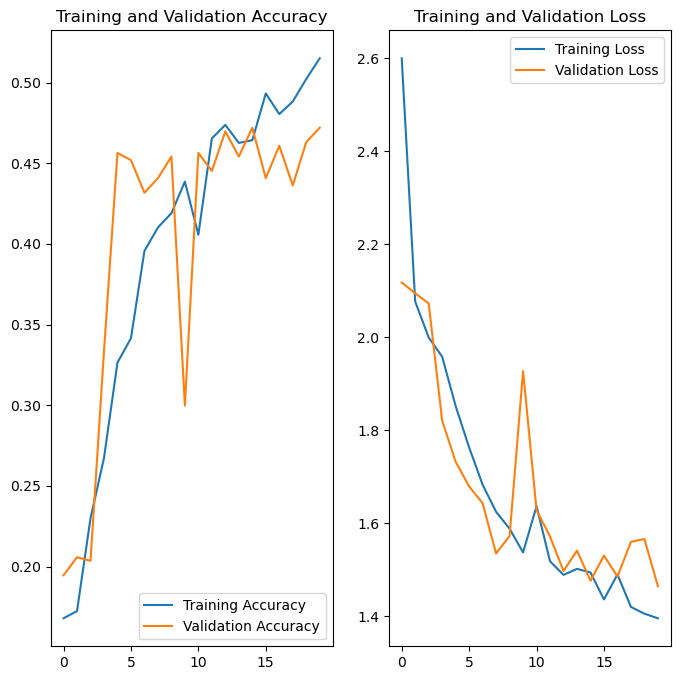

In [27]:
# Plot model performance
plot_model_outcome(history, epochs)

### Observation
Comparing with previous model performance:
* Overfitting issue is reduced after using dropout layer
* Model Performance of training dataset reduced. This can be due to the effect of data augumentation layer.
* Model Performance of validation dataset still not increased. Hence data augumentation layer is not helping in classifying the images accurately.
* Difference between loss and accuracy of train and validation have less margin.

### Distribution of dataset
Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

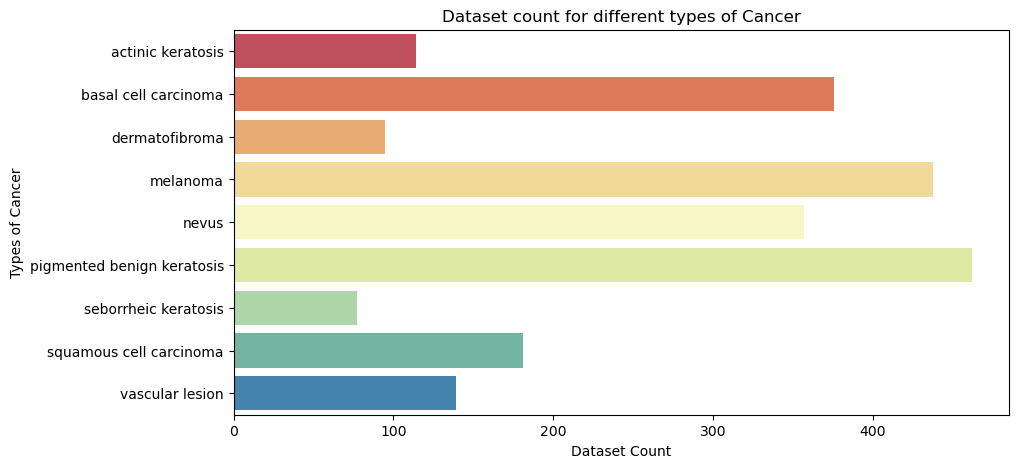

In [28]:
# Plotting training datasets availble for each type of Cancer
fig, ax = plt.subplots(figsize = (10, 5))
sns.barplot(y=class_names, x=count_files, palette = 'Spectral')
ax.set_ylabel("Types of Cancer")
ax.set_xlabel("Dataset Count")
ax.set_title("Dataset count for different types of Cancer")
ax.bar_label(ax.containers[0], fmt = '%d', padding = 3)
plt.show()

In [29]:
# Create a dataframe to understand images available in each classes
df = pd.DataFrame({'Class Names' : class_names, 'Image Count' : count_files})
df

,Class Names,Image Count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


### Observation

##### Which class has the least number of samples?
`seborrheic keratosis` has the least number of samples only 77.

##### Which classes dominate the data in terms proportionate number of samples?
`pigmented benign keratosis` (**462** Samples), `melanoma` (**438** Samples), `basal cell carcinoma` (**376** Samples), and `nevus` (**357** Samples) classes dominates the data in terms proportionate number of samples .

### Fix Class Imbalance Issue

To rectify the class imbalance issue, we will use python package `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
# Install Augmentor library
!pip install Augmentor

#### Procedure
To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [31]:
# Import Augmentor Library
path_to_training_dataset=data_dir_train
import Augmentor
# Instantiate pipeline to create additional images
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(data_dir_train, i)) # Changed base code to avoid error in new versions of augmentor
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10) # Rotate images to create new ones
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2AC3DC3A9A0>: 100%|█| 500/500 [00:03<00:


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2AC17BD2580>: 100%|█| 500/500 [00:04<00:00, 117.68 Samples


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2AC3DB89C40>: 100%|█| 500/500 [00:04<00:00, 111.57 Samples


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2AC118A2400>: 100%|█| 500/500 [00:21<00:00, 23.79 Samples


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x2AC10490A30>: 100%|█| 500/500 [00:21<00:00, 23.09 Samples/


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2AC1197C4C0>: 100%|█| 500/500 [00:04<00:00, 106.56 Samples


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x2AC11E5A4C0>: 100%|█| 500/500 [00:11<00


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2AC11C15E50>: 100%|█| 500/500 [00:04<00:00, 100.41 Samples


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x2AC1195A2B0>: 100%|█| 500/500 [00:04<00:


**Observation** : Augmentor has stored the augmented images in the `output` sub-directory of each of the sub-directories of skin cancer types.

### Distribution of Dataset
Lets see the distribution of augmented data after adding new images to the original training data.<br>
Changed base code to avoid errors and display it as dataframe

In [32]:
# Let's count files after Augmentor
count_files_new = []
for name in class_names:
    temp_path = os.path.join(data_dir_train, name) # Join file path with class name
    count = 0
    for root_dir, cur_dir, files in os.walk(temp_path):
        count += len(files)
    count_files_new.append(count) # Count all files
# Take difference
diff_amt = []
for i in range(num_classes):
    diff_amt.append(count_files_new[i] - count_files[i])

In [33]:
# Create a dataframe to display modified file count
files_dict = {'Labels' : class_names, 
              'Original Image Count' : count_files, 
              'New Image Count' : diff_amt,
              'Total Image Count' : count_files_new
             }
files_df = pd.DataFrame(files_dict)
files_df

,Labels,Original Image Count,New Image Count,Total Image Count
0,actinic keratosis,114,500,614
1,basal cell carcinoma,376,500,876
2,dermatofibroma,95,500,595
3,melanoma,438,500,938
4,nevus,357,500,857
5,pigmented benign keratosis,462,500,962
6,seborrheic keratosis,77,500,577
7,squamous cell carcinoma,181,500,681
8,vascular lesion,139,500,639


In [34]:
# Count total Images avaiable in train dataset
image_count_train = len(list(data_dir_train.rglob('*/*.jpg', )))
print('Train dataset now have {} images'.format(image_count_train))

Train dataset now have 6739 images


**Observation** : So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Prepare dataset
* Train the model on the data created using Augmentor
* Create training and validation dataset with 80-20 ratio
* Pre-fetch the images

In [35]:
# Resize images to the size img_height*img_width, while reading the dataset - training
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,
                                                       validation_split=0.2,
                                                       subset='training',
                                                       batch_size=batch_size,
                                                       image_size=(img_height, img_width),
                                                       seed=123)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [36]:
# Resize images to the size img_height*img_width, while reading the dataset - validation
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir_train,
                                                     validation_split=0.2,
                                                     subset='validation',
                                                     batch_size=batch_size,
                                                     image_size=(img_height, img_width),
                                                     seed=123)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [37]:
# Print shapes of image and labels of training and validation
for images, labels in train_ds.take(1): # take() - takes a single batch (images and label) from train_ds dataset
  print("The Training Batch is of shape {}, and the Classification labels are of shape {}".format(images.shape, labels.shape))

for images, labels in val_ds.take(1): # take() - takes a single batch (images and label) from val_ds dataset
  print("The Validation Batch is of shape {}, and the Classification labels are of shape {}".format(images.shape, labels.shape))

The Training Batch is of shape (32, 180, 180, 3), and the Classification labels are of shape (32,)
The Validation Batch is of shape (32, 180, 180, 3), and the Classification labels are of shape (32,)


In [38]:
# Pre-fecth buffer
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [39]:
# model
model = Sequential()

# At first, we will add rescaling layer to normalize pixel range from (0 to 255) to (0, 1)
model.add(layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=input_shape))

# First conv layer
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
# First max pool layer
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Dropout layer with 0.25 rate
model.add(layers.Dropout(0.25))

# Second conv layer
model.add(layers.Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
# Second max pool layer
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# Dropout layer with 0.25 rate
model.add(layers.Dropout(0.25))

# Third conv layer
model.add(layers.Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))
# Third max pool layer
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# Dropout layer with 0.25 rate
model.add(layers.Dropout(0.25))

# Flatten layer
model.add(layers.Flatten())

# Dense layer or fully connected layer
model.add(layers.Dense(512, activation='relu'))
# Dropout layer with 0.25 rate
model.add(layers.Dropout(0.25))

# Dense layer or fully connected layer
model.add(layers.Dense(64, activation='relu'))
# Dropout layer with 0.5 rate
model.add(layers.Dropout(0.5))

# Softmax layer
model.add(layers.Dense(num_classes, activation='softmax'))

### Compile the model

In [40]:
# Compile the model with optimiser and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [41]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 89, 89, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                  

### Understanding Model Summary
We are using same model as before without image augmentation layer!

### Train the model

We will train the model for 20 epochs first and then train it for 30 epochs. This will help us to compare the performance of model when epoch increases.

In [42]:
# epochs - training of the neural network with all the training data for one cycle
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 179s 987ms/step - loss: 2.3814 - accuracy: 0.1413 - val_loss: 2.1866 - val_accuracy: 0.1403
Epoch 2/20
169/169 [==============================] - 167s 988ms/step - loss: 2.1625 - accuracy: 0.1523 - val_loss: 2.1894 - val_accuracy: 0.1403
Epoch 3/20
169/169 [==============================] - 162s 955ms/step - loss: 2.1796 - accuracy: 0.1365 - val_loss: 2.1864 - val_accuracy: 0.1403
Epoch 4/20
169/169 [==============================] - 151s 891ms/step - loss: 2.1793 - accuracy: 0.1380 - val_loss: 2.1862 - val_accuracy: 0.1403
Epoch 5/20
169/169 [==============================] - 148s 877ms/step - loss: 2.1784 - accuracy: 0.1372 - val_loss: 2.1879 - val_accuracy: 0.1403
Epoch 6/20
169/169 [==============================] - 147s 868ms/step - loss: 2.1789 - accuracy: 0.1397 - val_loss: 2.1869 - val_accuracy: 0.1403
Epoch 7/20
169/169 [==============================] - 151s 891ms/step - loss: 2.1773 - accuracy: 0.1397 - val_loss: 2.1870 -

### Visualizing the results

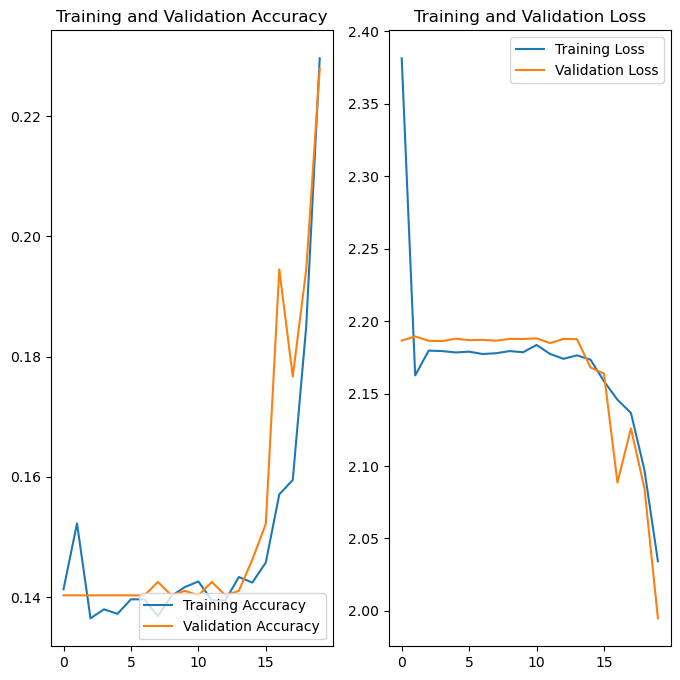

In [43]:
# Plot model performance
plot_model_outcome(history, epochs)

**Observation** : Validation data set accuracy is comparable with training data set as epoch increases. Eventhough the difference of loss of both data set have some margin when epoch is 20, still this model is acceptable.

### Evaluate the model

Evaluate the trained model with test data set.

In [44]:
# Function to evaluate a model on given test data
def evaluate_model(model, data_dir_test, img_height, img_width):
    # Resize images to the size img_height*img_width, while reading the dataset - test
    test_ds = tf.keras.utils.image_dataset_from_directory(data_dir_test,
                                                        image_size=(img_height, img_width))
    # Print shapes of image and labels of test dataset
    for images, labels in test_ds.take(1): # take() - takes a single batch (images and label) from test_ds dataset
        print("The Test Batch is of shape {}, and the Classification labels are of shape {}".format(images.shape, labels.shape))
    # Evaluate the Model
    return model.evaluate(test_ds)

In [45]:
# Evaluate model
evaluate_model(model, data_dir_test, img_height, img_width)

Found 118 files belonging to 9 classes.
The Test Batch is of shape (32, 180, 180, 3), and the Classification labels are of shape (32,)
4/4 [==============================] - 2s 117ms/step - loss: 2.1097 - accuracy: 0.2373


[2.1096975803375244, 0.23728813230991364]

**Observation** : Test data accuracy is 32.2% and loss is 6.14

### Predict classes using the model

Predict classes using the trained model. Create a confusion matrix and calculate accuracy of prediction.

In [46]:
# Function to predict classes from test data
def predict_classes(model, data_dir_test, img_height, img_width, num_classes, class_names):
    # Let's predict test data with our model
    actual = []
    predicted = []
    # Loop through all classes
    for i in range(num_classes):
      temp_path = os.path.join(data_dir_test, class_names[i]) # Join file path with class name
      for j in range(len(os.listdir(temp_path))):
        file = os.path.join(temp_path, os.listdir(temp_path)[j])
        img = load_img(file, target_size=(img_height, img_width)) # Load image
        img = keras.preprocessing.image.img_to_array(img) # Conver PIL to array
        img = np.expand_dims(img, axis=0) # Expand dimensions
        pred = model.predict(img, verbose=0) # Predict Image
        pred = np.argmax(pred) # Take argmax of probabilities to get class index
        actual.append(class_names[i]) # Get Actual Class Name
        predicted.append(class_names[pred]) # Get Predicted Class Name
    return actual, predicted

In [47]:
# Predict the classes from test data
actual, predicted = predict_classes(model, data_dir_test, img_height, img_width, num_classes, class_names)

In [48]:
# Function to generate Confusion matrix
def gen_conf_matrix(actual, predicted, class_names):
    confusion_matrix = metrics.confusion_matrix(actual, predicted)

    # Display confusion matrix
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_names)
    cm_display.plot()
    plt.xticks(rotation = 90)
    plt.show()

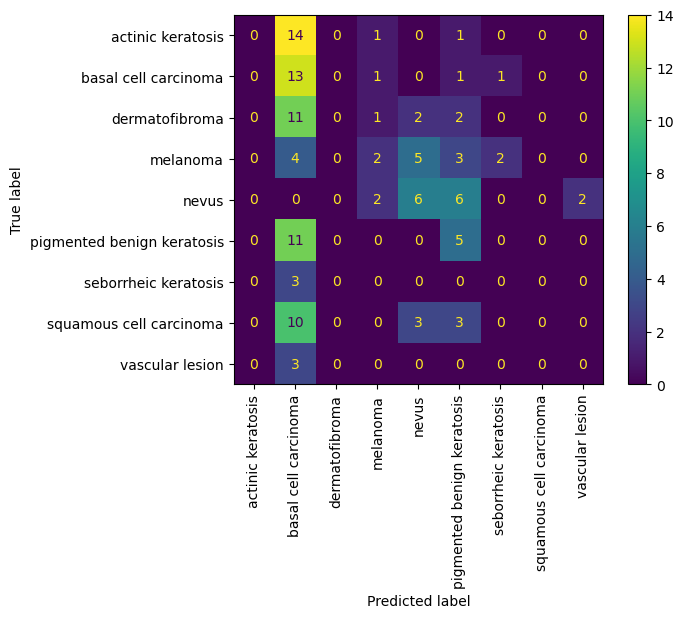

In [49]:
# Display confusion matrix
gen_conf_matrix(actual, predicted, class_names)

In [50]:
# Get Classification Report
print(metrics.classification_report(actual, predicted, target_names=class_names))

                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.19      0.81      0.31        16
            dermatofibroma       0.00      0.00      0.00        16
                  melanoma       0.29      0.12      0.17        16
                     nevus       0.38      0.38      0.38        16
pigmented benign keratosis       0.24      0.31      0.27        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.00      0.00      0.00        16
           vascular lesion       0.00      0.00      0.00         3

                  accuracy                           0.22       118
                 macro avg       0.12      0.18      0.13       118
              weighted avg       0.15      0.22      0.15       118



**Observation** : We can see overall test accuracy is very less. But from confusion matrix, we can see that the precision, recall f1-score explains how each class prediction will work.
For melanoma, we have precision score of 0.18 and recall of 0.12.

### Train the model with **30 Epochs**

#### Create and Compile the model

In [51]:
# model
new_model = Sequential()

# At first, we will add rescaling layer to normalize pixel range from (0 to 255) to (0, 1)
new_model.add(layers.experimental.preprocessing.Rescaling(1. / 255, input_shape=input_shape))

# First conv layer
new_model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu'))
# First max pool layer
new_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# Dropout layer with 0.25 rate
new_model.add(layers.Dropout(0.25))

# Second conv layer
new_model.add(layers.Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
# Second max pool layer
new_model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# Dropout layer with 0.25 rate
new_model.add(layers.Dropout(0.25))

# Third conv layer
new_model.add(layers.Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))
# Third max pool layer
new_model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# Dropout layer with 0.25 rate
new_model.add(layers.Dropout(0.25))

# Flatten layer
new_model.add(layers.Flatten())

# Dense layer or fully connected layer
new_model.add(layers.Dense(512, activation='relu'))
# Dropout layer with 0.25 rate
new_model.add(layers.Dropout(0.25))

# Dense layer or fully connected layer
new_model.add(layers.Dense(64, activation='relu'))
# Dropout layer with 0.5 rate
new_model.add(layers.Dropout(0.5))

# Softmax layer
new_model.add(layers.Dense(num_classes, activation='softmax'))

In [52]:
# Compile the model with optimiser and loss function
new_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [53]:
# View the summary of all layers
new_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 89, 89, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                 

#### Understanding Model Summary
We are using same model as before without image augmentation layer!

#### Train the model
Train the model with 30 epochs.

In [54]:
# epochs - training of the neural network with all the training data for one cycle
epochs = 30
history = new_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 144s 844ms/step - loss: 2.3093 - accuracy: 0.1884 - val_loss: 1.9871 - val_accuracy: 0.3229
Epoch 2/30
169/169 [==============================] - 146s 861ms/step - loss: 1.8888 - accuracy: 0.2975 - val_loss: 1.8147 - val_accuracy: 0.3571
Epoch 3/30
169/169 [==============================] - 146s 863ms/step - loss: 1.6686 - accuracy: 0.3674 - val_loss: 1.4937 - val_accuracy: 0.4395
Epoch 4/30
169/169 [==============================] - 150s 888ms/step - loss: 1.5328 - accuracy: 0.4125 - val_loss: 1.3918 - val_accuracy: 0.4744
Epoch 5/30
169/169 [==============================] - 146s 863ms/step - loss: 1.4548 - accuracy: 0.4355 - val_loss: 1.4698 - val_accuracy: 0.4491
Epoch 6/30
169/169 [==============================] - 146s 862ms/step - loss: 1.4025 - accuracy: 0.4588 - val_loss: 1.4596 - val_accuracy: 0.4744
Epoch 7/30
169/169 [==============================] - 145s 860ms/step - loss: 1.3856 - accuracy: 0.4694 - val_loss: 1.2582 -

#### Visualize the result

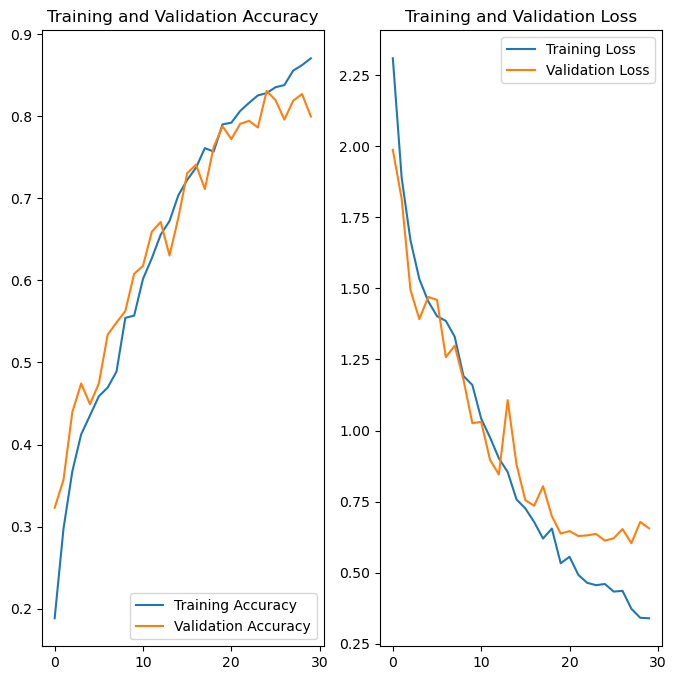

In [56]:
# Plot model performance
plot_model_outcome(history, epochs)

**Observation** : Validation data set accuracy decreases as epoch increases, when compared to training data set. Eventhough the difference of loss of both data set have some margin when epoch reaches 30, still this model is acceptable.

#### Evaluate the model

Evaluate the trained model with test data set.

In [57]:
# Evaluate model
evaluate_model(new_model, data_dir_test, img_height, img_width)

Found 118 files belonging to 9 classes.
The Test Batch is of shape (32, 180, 180, 3), and the Classification labels are of shape (32,)
4/4 [==============================] - 3s 116ms/step - loss: 5.5697 - accuracy: 0.3475


[5.569662094116211, 0.347457617521286]

**Observation** : Test data accuracy is 38.89% and loss is 4.93.

#### Predict classes using the model

Predict classes using the trained model. Create a confusion matrix and calculate accuracy of prediction.

In [58]:
# Predict the classes from test data
actual, predicted = predict_classes(new_model, data_dir_test, img_height, img_width, num_classes, class_names)

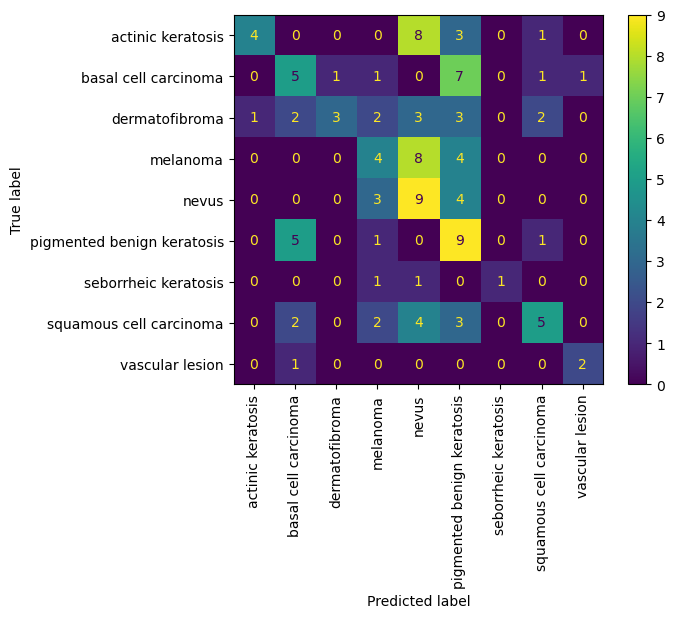

In [59]:
# Display confusion matrix
gen_conf_matrix(actual, predicted, class_names)

In [60]:
# Get Classification Report
print(metrics.classification_report(actual, predicted, target_names=class_names))

                            precision    recall  f1-score   support

         actinic keratosis       0.80      0.25      0.38        16
      basal cell carcinoma       0.33      0.31      0.32        16
            dermatofibroma       0.75      0.19      0.30        16
                  melanoma       0.29      0.25      0.27        16
                     nevus       0.27      0.56      0.37        16
pigmented benign keratosis       0.27      0.56      0.37        16
      seborrheic keratosis       1.00      0.33      0.50         3
   squamous cell carcinoma       0.50      0.31      0.38        16
           vascular lesion       0.67      0.67      0.67         3

                  accuracy                           0.36       118
                 macro avg       0.54      0.38      0.40       118
              weighted avg       0.48      0.36      0.35       118



**Observation** : Model performs better with epoch 30. This clearly affected the test data accurracy and loss. Hence we will select the model with epoch 30 as our final model.<br>
Also confusion matrix shows how this `model` misclassifies the test data more than `new_model`.<br>
Again precision and recall score is more when compared to previous model run!

### Predict an image
We will use the `new_model` to predict an image from test data set.

Actual Class is nevus and Predicted Class is nevus




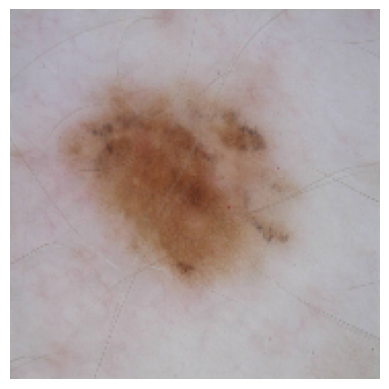

In [61]:
# Predict one image from one class from test data set.
temp_path = os.path.join(data_dir_test, class_names[4]) # Join file path with one class name
file = os.path.join(temp_path, os.listdir(temp_path)[-1]) # Get a file
img = load_img(file, target_size=(img_height, img_width)) # Load image
img = keras.preprocessing.image.img_to_array(img) # Conver PIL to array
img = np.expand_dims(img, axis=0) # Expand dimensions
pred = new_model.predict(img, verbose=0) # Predict Image
pred = np.argmax(pred) # Take argmax of probabilities to get class index
print('Actual Class is {0} and Predicted Class is {1}\n\n'.format(class_names[4], class_names[pred]))
plt.imshow(load_img(file, target_size=(img_height, img_width))) # Show images
plt.axis("off") # turn off axis for image display
plt.show()

### Final Observation

* Class rebalance helps in augmentation and achieving the best Training and validation accuracy.
* Model overfitting issue is solved.
* Model trained on the rectified class imbalance data with 30 epochs is chosen to classify 9 types of skin cancer accurately.

### Model Summary

Training data set loss: 0.32<br>
Training data set accuracy: 88.23 %<br>
<br>
Validation data set loss: 0.74<br>
Validation data set accuracy: 79.81 %<br>
<br>
Test data set loss: 3.9<br>
Test data set accuracy: 38.98 %<br>
<br>
<hr style="border:1px solid blue">